# 04.Modelado predictivo con ML

### Importacion de la data

In [78]:
import pandas as pd
import numpy as np
df_news=pd.read_csv("C:/Repos/Projecto_TRM/Datos/noticias_bitcoin_sentimientos.csv")
df_btc=pd.read_csv("C:/Repos/Projecto_TRM/Datos/BTC_USD_Media_Movil.csv")
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1096 non-null   object 
 1   Close      1096 non-null   float64
 2   High       1096 non-null   float64
 3   Low        1096 non-null   float64
 4   Open       1096 non-null   float64
 5   Volume     1096 non-null   float64
 6   Close_7d   1090 non-null   float64
 7   Volume_7d  1090 non-null   float64
dtypes: float64(7), object(1)
memory usage: 68.7+ KB


In [2]:
df_news.head()

,fecha,titulo,descripcion,contenido,url,fuente,score
0,2025-04-07,Bitcoin price falls amid tariff market rout,"Bitcoin, the world's largest cryptocurrency by...","The price of bitcoin (BTC-USD), the world's la...",https://ca.finance.yahoo.com/news/bitcoin-pric...,Yahoo Canada Finance,-0.536233
1,2025-04-07,US crypto stocks plunge as bitcoin hits new 20...,U.S.-listed shares of crypto companies tumbled...,(Reuters) - U.S.-listed shares of crypto compa...,https://finance.yahoo.com/news/us-crypto-stock...,Yahoo Finance,-0.637867
2,2025-04-05,SpaceX tourists return to Earth after historic...,Bitcoin investor Chun Wang took three people o...,Four space tourists have safely arrived back o...,https://news.sky.com/story/spacex-tourists-ret...,Sky News,0.630636
3,2025-04-04,BlackRock buys $66M in Bitcoin amid market crash,BlackRock acquired $66 million in Bitcoin on t...,The sell-off in the stock market didn’t cool d...,https://finance.yahoo.com/news/blackrock-buys-...,Yahoo Finance,-0.137903
4,2025-04-04,Markets tumble as Trump launches ‘Unstoppable’...,Markets fell after Trump announced new tariffs...,"On April 3, markets worldwide dropped sharply ...",https://finance.yahoo.com/news/markets-tumble-...,Yahoo Finance,-0.489370


## Preprosesamiento de la data

In [3]:
df_news['fecha'] = pd.to_datetime(df_news['fecha'], format='%Y-%m-%d')

df_news_avg_score = df_news.groupby('fecha')['score'].mean().reset_index()

In [4]:
import plotly.express as px

fig = px.line(df_news_avg_score, x='fecha', y='score', title='Promedio del Score a lo Largo del Tiempo', markers=True)
fig.update_layout(xaxis_title='Fecha', yaxis_title='Avg Score', template='plotly_white')
fig.show()


## Implementacion del modelo

In [83]:
btc_index = df_btc.set_index(pd.to_datetime(df_btc['Date']))['Close'].dropna()
btc_index.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1096 entries, 2022-04-06 to 2025-04-05
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


Necesitamos analizar si sus propiedades estadisticas no cambian a lo largo del tiempo. Para ello es necesario aplicar Dickey-Fuller para llegar a una conclusion y actuar a partir de ahi.

### Analisis de Estacionariedad

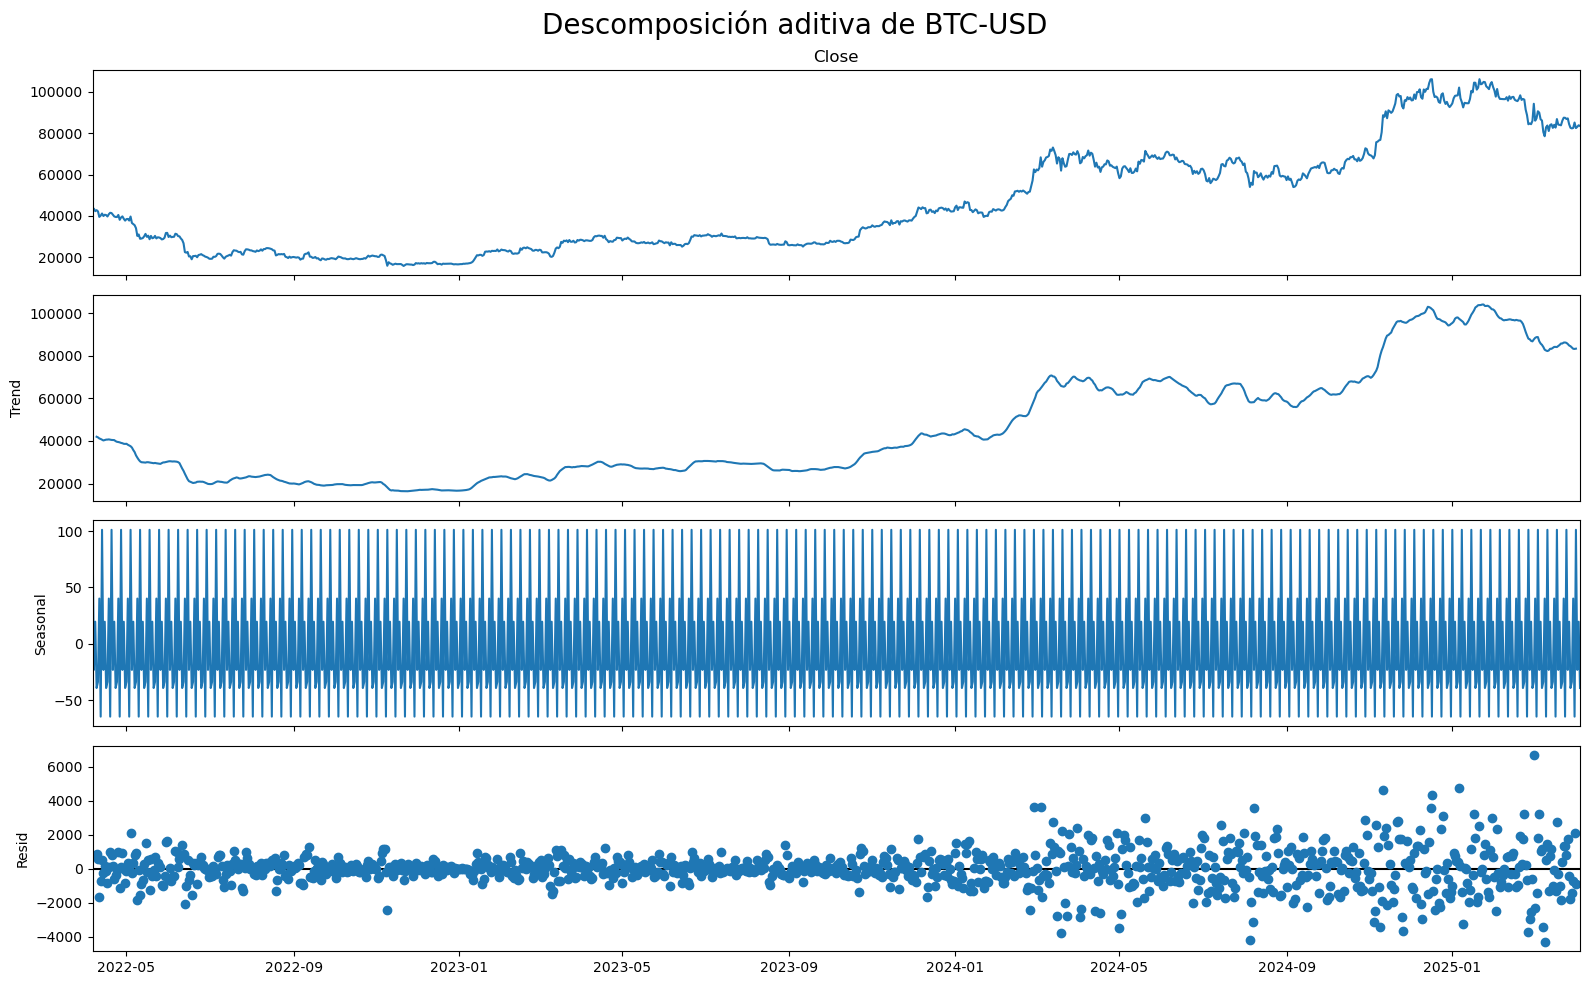

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Descomposición
result = seasonal_decompose(btc_index, model='additive', period=7)  # puedes ajustar el periodo si conoces una estacionalidad clara
fig = result.plot()
fig.set_size_inches(16, 10)
plt.suptitle('Descomposición aditiva de BTC-USD', fontsize=20)
plt.tight_layout()
plt.show()

### Prueba Dickey Fuller

#### Definimos la funcion para implementar la prueba

In [88]:
from statsmodels.tsa.stattools import adfuller

def prueba_adf(serie, nombre_serie='Serie'):
    """
    Aplica la prueba ADF a una serie temporal y muestra el resultado con interpretación.

    Parámetros:
    - serie: Serie temporal (pandas Series)
    - nombre_serie: Nombre descriptivo de la serie para el encabezado del resultado
    """
    resultado_adf = adfuller(serie.dropna())

    print(f'\n--- Prueba ADF (Augmented Dickey-Fuller) para {nombre_serie} ---')
    print(f'Estadístico ADF: {resultado_adf[0]}')
    print(f'Valor p: {resultado_adf[1]}')
    print('Valores críticos:')
    for key, value in resultado_adf[4].items():
        print(f'   {key}: {value}')

    if resultado_adf[1] <= 0.05:
        print(f"\n✅ {nombre_serie} es estacionaria (rechazamos H0).")
    else:
        print(f"\n❌ {nombre_serie} NO es estacionaria (no se rechaza H0).")


#### Con la serie Original

In [90]:
prueba_adf(df_btc['Close'], 'Precio de cierre del Bitcoin Original')



--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Original ---
Estadístico ADF: -0.41277959626419064
Valor p: 0.9079430766815466
Valores críticos:
   1%: -3.4364081161854747
   5%: -2.8642149051061954
   10%: -2.5681942108302214

❌ Precio de cierre del Bitcoin Original NO es estacionaria (no se rechaza H0).


####  Con la serie diferenciada

In [93]:
serie_diff = df_btc['Close'].diff().dropna()
prueba_adf(serie_diff, 'Precio de cierre del Bitcoin Diferenciado')



--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Diferenciado ---
Estadístico ADF: -7.9996339957446745
Valor p: 2.352876572073833e-12
Valores críticos:
   1%: -3.4364081161854747
   5%: -2.8642149051061954
   10%: -2.5681942108302214

✅ Precio de cierre del Bitcoin Diferenciado es estacionaria (rechazamos H0).


Vemos que paso la prueba y no tiene fuertes tendencias, ni varianza cambiante por lo que lo revisamos a continuacion:

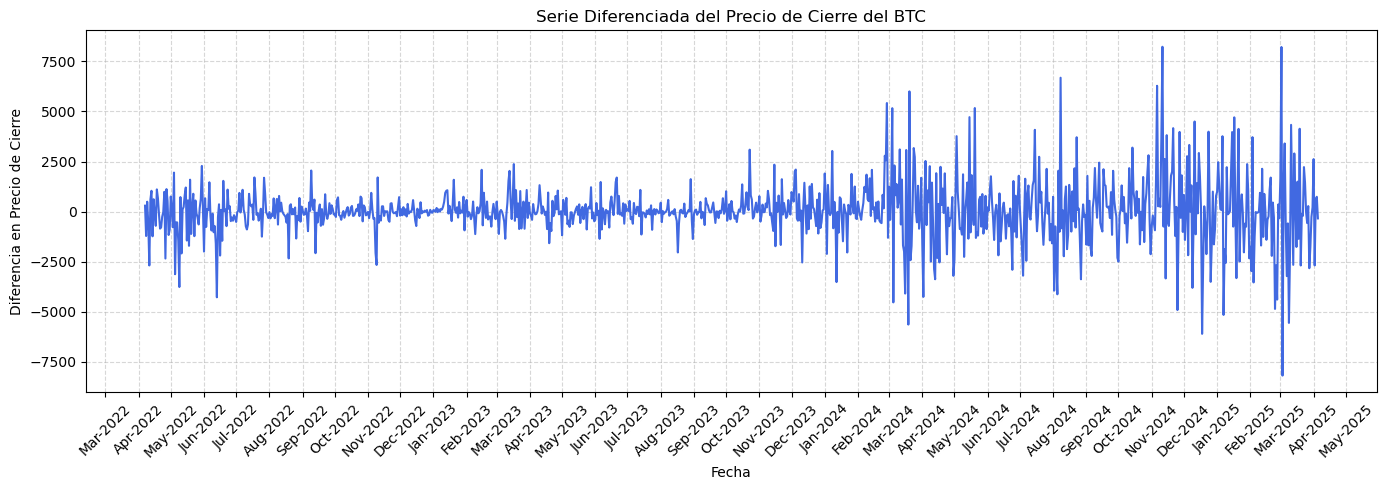

In [107]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asegúrate de que las fechas sean tipo datetime
df_btc['Date'] = pd.to_datetime(df_btc['Date'])

# Crear la figura
plt.figure(figsize=(14, 5))
plt.plot(df_btc['Date'][2:], serie_diff.values, color='royalblue')

# Títulos y etiquetas
plt.title('Serie Diferenciada del Precio de Cierre del BTC')
plt.xlabel('Fecha')
plt.ylabel('Diferencia en Precio de Cierre')

# Configurar el eje X para mostrar ticks mensuales
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Un tick por mes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # Formato como Ene-2022

# Mejoras visuales
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Vemos que los valores de la serie diferenciada giran entorno al eje horizontal y no se observan tendencias marcadas. Vemos que a partir de

## Analisis con Prophet

In [ ]:
pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB 9.6 MB/s eta 0:00:02
   - -------------------------------------- 0.6/13.3 MB 7.7 MB/s eta 0:00:02
   ---- ----------------------------------- 1.4/13.3 MB 10.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.8/13.3 MB 10.5 MB/s eta 0:00:02
   ------- -------------------------------- 2.4/13.3 MB 11.1 MB/s eta 0:00:01
   -------- ------------------------------- 3.0/13.3 MB 11.2 MB/s eta 0:00:01
   ----------- ---------------------------- 3.7/13.3 MB 11.3 MB/s eta 0:00:01
   ------------- -------------------------- 4.6/13.3 MB 11.3 MB/s eta 0:00:01
   --------------- ------------------------ 5.3/13.3 MB 11.2 MB/s eta 0:00:01
   ----------------- ---------------------- 5.8/13.3 MB 11.3 MB/s eta 0:00:01
   ------------------- -------------------- 6.5/13.3 MB 11.5 MB/s eta 0:00:01
   --------------------- ------------------ 7.1/13.3 MB 11.4 MB/s eta 0:00

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error

#############################################
# 1) Prepare Data for Prophet
#############################################

# Suppose eth_df has a Date index and a column named 'price'.
# Example schema: eth_df.columns -> ['price'], eth_df.index -> DatetimeIndex

# Reset index to turn the Date into a column named 'ds'
prophet_df = df_btc[['Date','Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
# 'ds' must be datetime, 'y' is the numeric value to forecast
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Train/Test Split
train_size = int(len(prophet_df) * 0.8)
train_prophet = prophet_df[:train_size].copy()
test_prophet  = prophet_df[train_size:].copy()


print("[DEBUG] Prophet univariate data:")
print(prophet_df.head())

[DEBUG] Prophet univariate data:
   index         ds             y
0      0        NaT           NaN
1      1 2022-04-06  43206.738281
2      2 2022-04-07  43503.847656
3      3 2022-04-08  42287.664062
4      4 2022-04-09  42782.136719


In [ ]:
prophet_df.dropna(inplace=True)
prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 1 to 1096
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   1096 non-null   int64         
 1   ds      1096 non-null   datetime64[ns]
 2   y       1096 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 34.2 KB


In [ ]:
train_prophet = train_prophet[['ds', 'y']]
test_prophet = test_prophet[['ds', 'y']]


In [ ]:
print(train_prophet.head())
print(test_prophet.head())

          ds             y
0        NaT           NaN
1 2022-04-06  43206.738281
2 2022-04-07  43503.847656
3 2022-04-08  42287.664062
4 2022-04-09  42782.136719
            ds             y
877 2024-08-29  59388.179688
878 2024-08-30  59119.476562
879 2024-08-31  58969.898438
880 2024-09-01  57325.488281
881 2024-09-02  59112.480469


In [ ]:
import prophet
print(prophet.__version__)


1.1.6


In [ ]:
pip install cmdstanpy

In [ ]:
pip install --upgrade prophet


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # <-- faltaba esto

# Inicializar modelo Prophet
m_baseline = Prophet(daily_seasonality=True)
m_baseline.fit(train_prophet)

# Crear un dataframe futuro con la longitud del test
future_baseline = m_baseline.make_future_dataframe(periods=len(test_prophet))
forecast_baseline = m_baseline.predict(future_baseline)

# Evaluar RMSE en el test
merged_baseline = pd.merge(
    test_prophet[['ds', 'y']],
    forecast_baseline[['ds', 'yhat']],
    on='ds', how='left'
)
rmse_baseline = np.sqrt(mean_squared_error(merged_baseline['y'], merged_baseline['yhat']))
print(f"\n[DEBUG] Baseline Prophet RMSE: {rmse_baseline:.4f}")

# Graficar el forecast
fig = m_baseline.plot(forecast_baseline)
plt.title("Prophet Baseline Forecast (No Sentiment)")
plt.show()


AttributeError: 'Prophet' object has no attribute 'stan_backend'